In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import copy
import folium

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Amsterdam
amsterdam_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekdays.csv')
amsterdam_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekends.csv')

#Athens
athens_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekdays.csv')
athens_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekends.csv')

#Barcelona
barcelona_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv')
barcelona_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekends.csv')

#Berlin
berlin_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekdays.csv')
berlin_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekends.csv')

#Budapest
budapest_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekdays.csv')
budapest_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekends.csv')

#Lisbon
lisbon_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekdays.csv')
lisbon_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekends.csv')

#London
london_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekdays.csv')
london_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekends.csv')

#Paris
paris_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekdays.csv')
paris_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekends.csv')

#Rome
rome_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekdays.csv')
rome_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekends.csv')

#Vienna
vienna_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekdays.csv')
vienna_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekends.csv')

In [3]:
# path = "/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv"
# df = pd.read_csv(path, index_col=0)
# df.head()

In [4]:
datasets = [
    (amsterdam_weekdays, "Amsterdam", True),
    (amsterdam_weekend, "Amsterdam", False),
    (athens_weekdays, "Athens", True),
    (athens_weekend, "Athens", False),
    (barcelona_weekdays, "Barcelona", True),
    (barcelona_weekend, "Barcelona", False),
    (berlin_weekdays, "Berlin", True),
    (berlin_weekend, "Berlin", False),
    (budapest_weekdays, "Budapest", True),
    (budapest_weekend, "Budapest", False),
    (lisbon_weekdays, "Lisbon", True),
    (lisbon_weekend, "Lisbon", False),
    (london_weekdays, "London", True),
    (london_weekend, "London", False),
    (paris_weekdays, "Paris", True),
    (paris_weekend, "Paris", False),
    (rome_weekdays, "Rome", True),
    (rome_weekend, "Rome", False),
    (vienna_weekdays, "Vienna", True),
    (vienna_weekend, "Vienna", False)
]

df = pd.DataFrame()

for data, city, is_weekday in datasets:
    data['city'] = city
    data['weekday'] = is_weekday
    df = pd.concat([df, data], ignore_index=True)

df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

print(df.head())
print(df.shape)

      realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378

# Data Exploration Process

## Pre-Processing

### Add data shuffle

In [5]:
np.random.seed(144)
df = df.sample(frac=1).reset_index(drop=True)

### DEALING WITH MISSING VALUES

In [6]:
df.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


In [7]:
df.shape

(51707, 21)

In [8]:
df = df.dropna()
df.shape

(51707, 21)

### Remove OUTLIERS

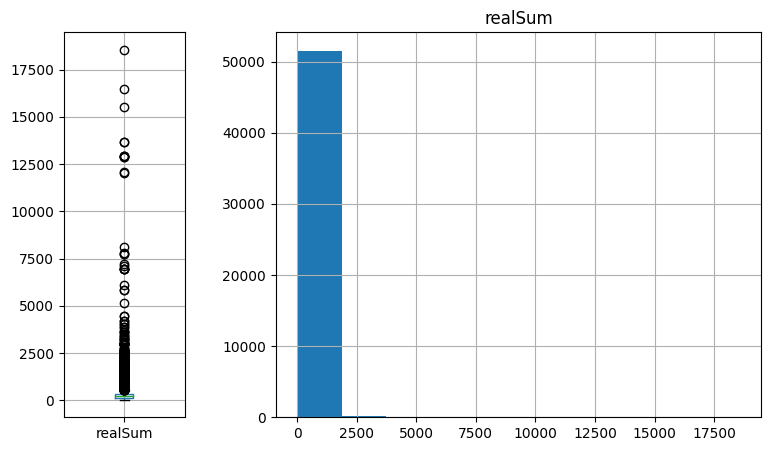

In [9]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='realSum',ax=axes[0]);
df.hist(column='realSum', ax=axes[1]);

In [10]:
Q1 = df['realSum'].quantile(0.25)
Q3 = df['realSum'].quantile(0.75)
IQR = Q3 - Q1

In [11]:
small_outliers = df['realSum'] < (Q1 - 1.5 * IQR)
big_outliers = df['realSum'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 3662)

In [12]:
df['realSum'][small_outliers | big_outliers].head()

60     698.806972
66     956.983937
83     593.852160
95     636.702364
99    2311.738714
Name: realSum, dtype: float64

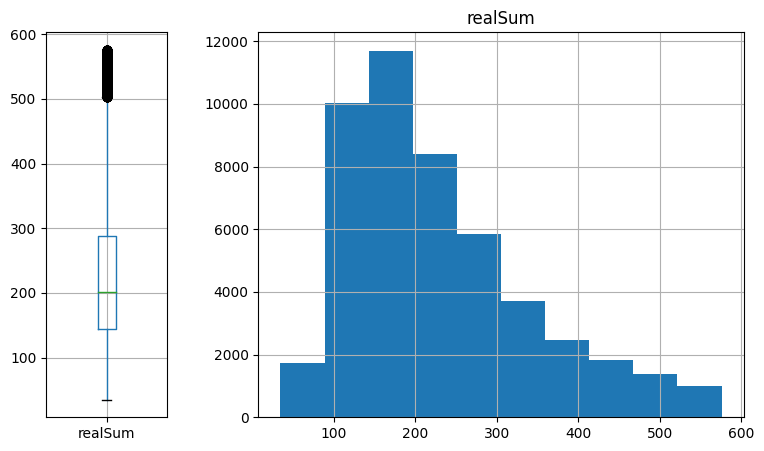

In [13]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df[~(small_outliers | big_outliers)].boxplot(column='realSum',ax=axes[0]);
df[~(small_outliers | big_outliers)].hist(column='realSum', ax=axes[1]);

In [14]:
df = df[~(small_outliers | big_outliers)]
df.shape

(48045, 21)

In [15]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
dtype: object

## Data Clustering

In [16]:
df_copy = df.copy()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

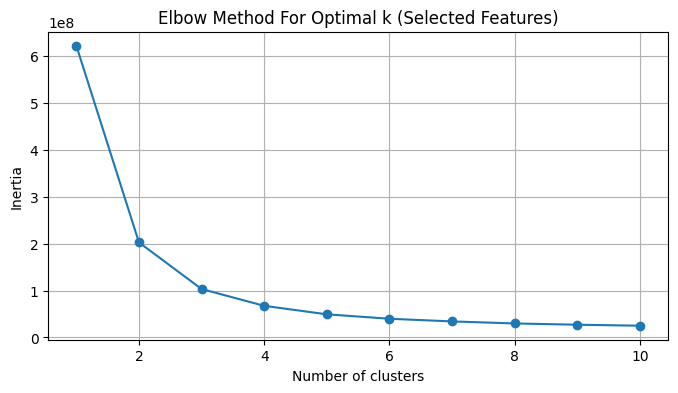

In [17]:
# Prepare data for clustering (selected features)
selected_features = ['realSum', 'person_capacity', 'bedrooms', 'attr_index_norm', 'rest_index_norm']
feature_data = df[selected_features]

# Determine the optimal number of clusters using the elbow method for the selected features
inertia_selected_features = []
K = range(1, 11)  # Test 1 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(feature_data)
    inertia_selected_features.append(kmeans.inertia_)

# Plotting the elbow curve for the selected features
plt.figure(figsize=(8, 4))
plt.plot(K, inertia_selected_features, 'o-')
plt.title('Elbow Method For Optimal k (Selected Features)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


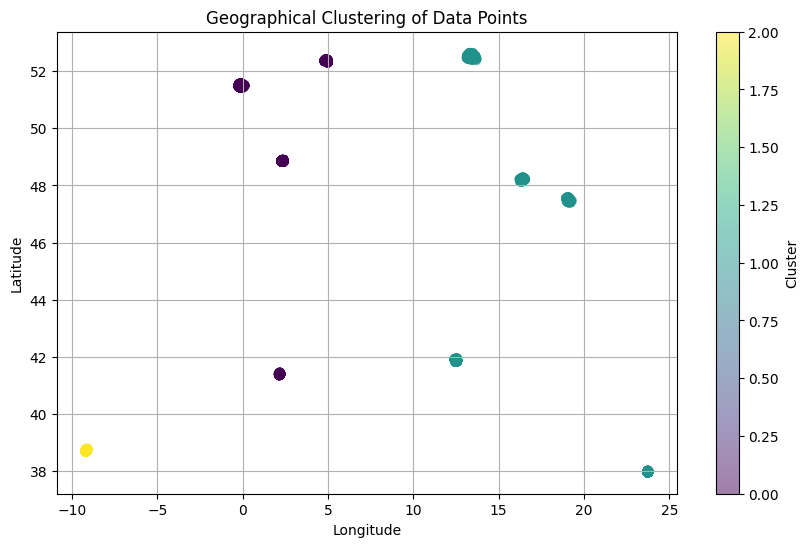

In [18]:
# Prepare data for clustering (selected features)
selected_features = ['lat', 'lng']
geo_data = df[selected_features]

# Clustering with K-means using the optimal number of clusters found (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
df_copy['cluster'] = kmeans.fit_predict(geo_data)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_copy['lng'], df_copy['lat'], c=df_copy['cluster'], alpha=0.5, cmap='viridis')
plt.title('Geographical Clustering of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


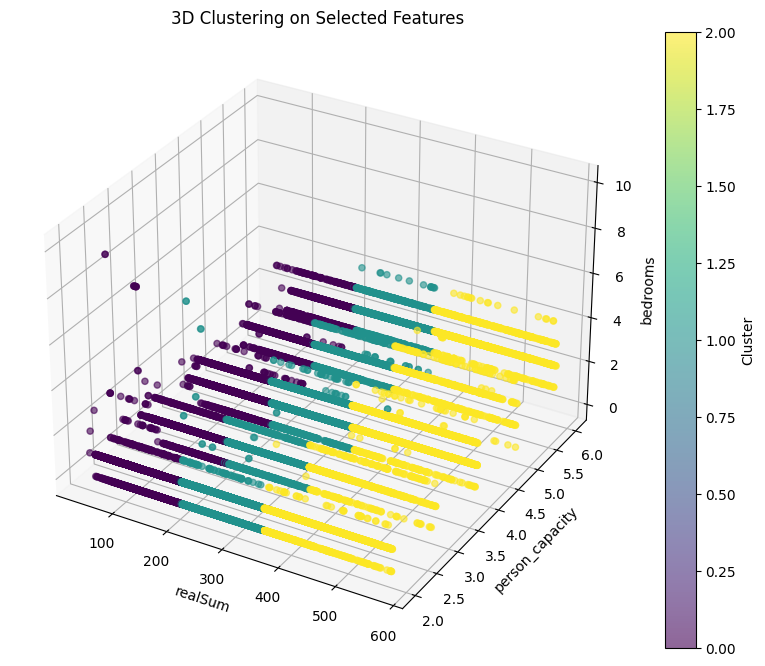

In [19]:
# Clustering with K-means using the optimal number of clusters found (k=3) for selected features
kmeans_features = KMeans(n_clusters=3, random_state=42)
df_copy['feature_cluster'] = kmeans_features.fit_predict(feature_data)

# Visualizing the clusters in a 3D plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_copy['realSum'],
                     df_copy['person_capacity'],
                     df_copy['bedrooms'],
                     c=df_copy['feature_cluster'],
                     cmap='viridis',
                     alpha=0.6)

# Labels and title
ax.set_xlabel('realSum')
ax.set_ylabel('person_capacity')
ax.set_zlabel('bedrooms')
plt.title('3D Clustering on Selected Features')
plt.colorbar(scatter, label='Cluster')

plt.show()

## Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


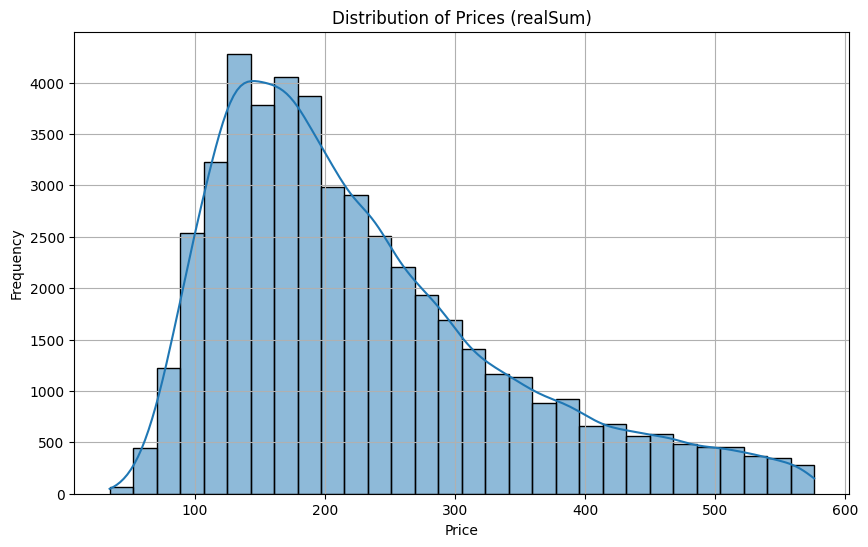

<function matplotlib.pyplot.show(close=None, block=None)>

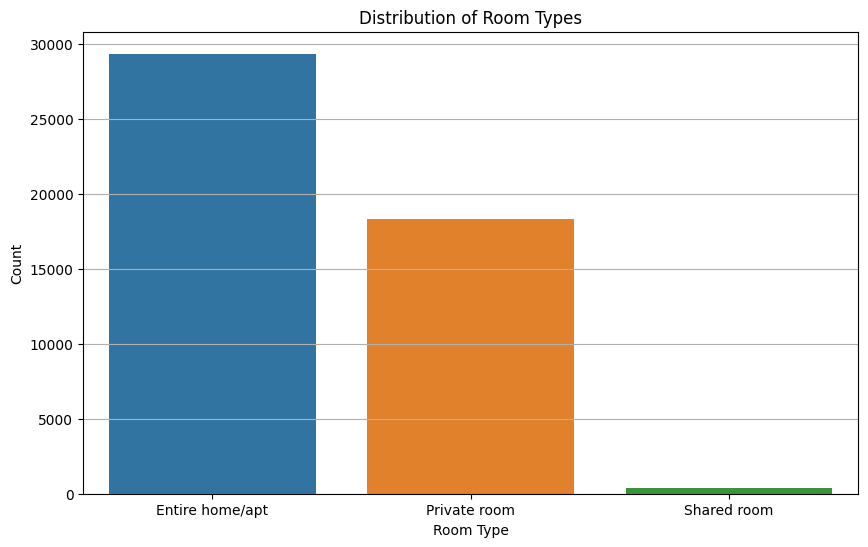

In [20]:
# 1. Summary Statistics for 'realSum'
plt.figure(figsize=(10, 6))
sns.histplot(df['realSum'], bins=30, kde=True)
plt.title('Distribution of Prices (realSum)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Distribution of Room Types
plt.figure(figsize=(10, 6))
sns.countplot(x='room_type', data=df)
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show

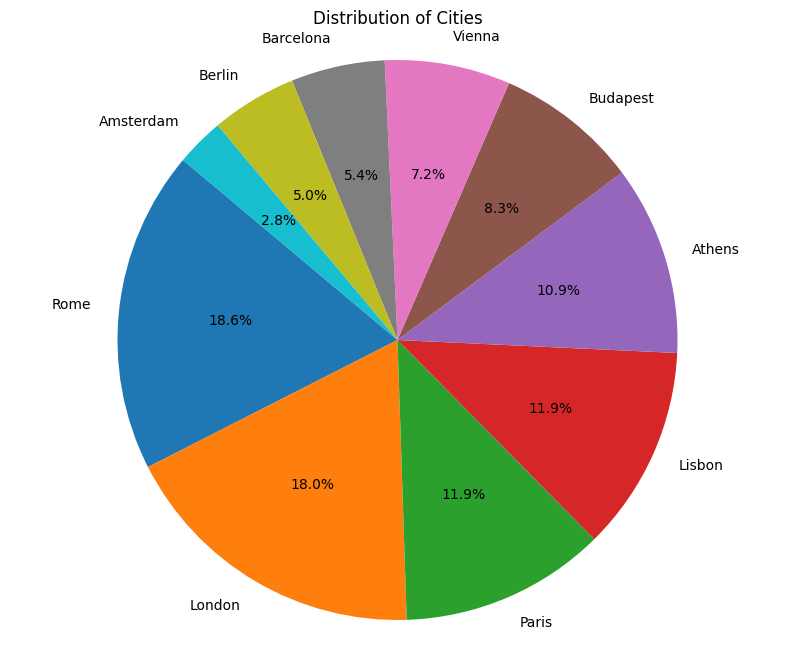

In [21]:
# Count occurrences of each city
city_counts = df['city'].value_counts()

# Plotting
plt.figure(figsize=(10, 8))
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Cities')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [22]:
# sns.pairplot(data=df[["realSum", "room_type", "person_capacity", "bedrooms", "rest_index", "city"]], hue='realSum');

In [23]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
dtype: object

## Feature Selection/Extraction:

In [24]:
# Encode categorical features
label_encoders = {}
for column in ['room_type', 'city']:
    le = LabelEncoder()
    df_copy[column] = le.fit_transform(df_copy[column])
    label_encoders[column] = le

# Convert boolean columns to int (True/False to 1/0)
bool_columns = ['room_shared', 'room_private', 'host_is_superhost', 'weekday']
for column in bool_columns:
    df_copy[column] = df_copy[column].astype(int)

# Show the updated dataframe and check types again
df_copy.head(), df_copy.dtypes

(      realSum  room_type  room_shared  room_private  person_capacity  \
 0  274.875535          0            0             0              5.0   
 1  162.397769          0            0             0              5.0   
 2  289.834747          0            0             0              2.0   
 3  183.148476          1            0             1              2.0   
 4  524.471413          0            0             0              2.0   
 
    host_is_superhost  multi  biz  cleanliness_rating  \
 0                  0      1    0                10.0   
 1                  0      1    0                10.0   
 2                  1      0    1                10.0   
 3                  0      0    0                10.0   
 4                  0      0    1                10.0   
 
    guest_satisfaction_overall  ...  attr_index  attr_index_norm  rest_index  \
 0                        96.0  ...  140.464780        10.059487  236.724193   
 1                        83.0  ...   65.647944         

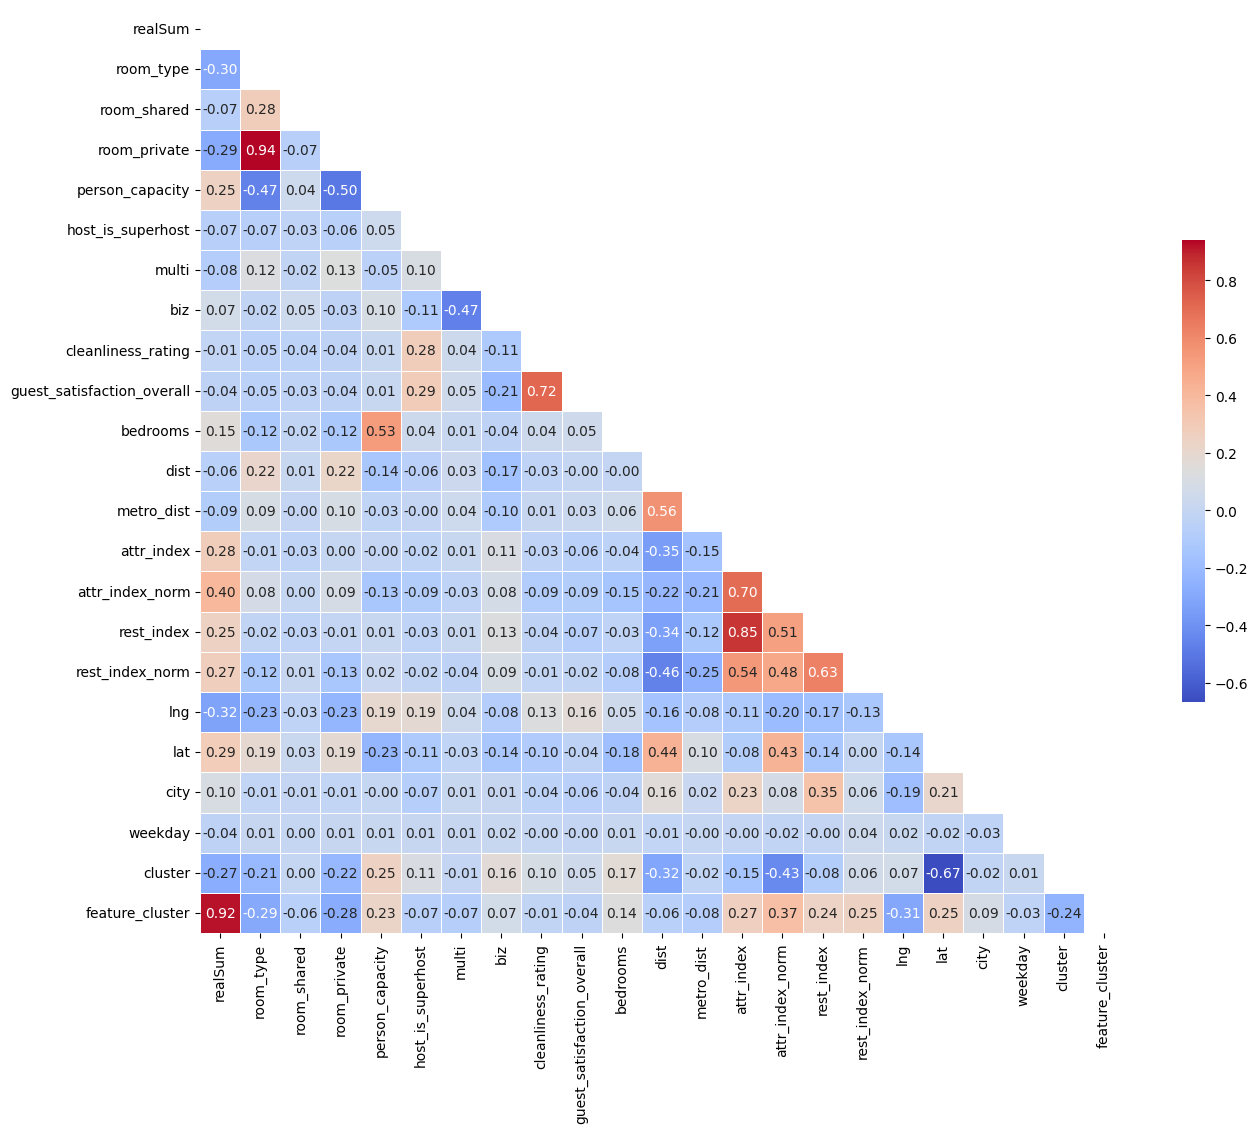

In [25]:
# Compute the correlation matrix
corr_matrix = df_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show plot
plt.show()

In [26]:
# Calculate the correlation matrix
correlation_matrix = df_copy.corr()

# Filter out columns where the correlation with 'realSum' is between -0.1 and 0.1
low_correlation_columns = correlation_matrix[(correlation_matrix['realSum'] > -0.1) & (correlation_matrix['realSum'] < 0.1)].index

# Print the columns with low correlation
print(low_correlation_columns)

# Remove these columns from the dataset
df_reduced = df.drop(columns=low_correlation_columns)
print(df_reduced.head())

Index(['room_shared', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'dist',
       'metro_dist', 'weekday'],
      dtype='object')
      realSum        room_type  room_private  person_capacity  bedrooms  \
0  274.875535  Entire home/apt         False              5.0         2   
1  162.397769  Entire home/apt         False              5.0         2   
2  289.834747  Entire home/apt         False              2.0         0   
3  183.148476     Private room          True              2.0         0   
4  524.471413  Entire home/apt         False              2.0         0   

   attr_index  attr_index_norm  rest_index  rest_index_norm       lng  \
0  140.464780        10.059487  236.724193         5.659063  16.38100   
1   65.647944         2.475200   96.679149         7.259259  23.73200   
2   87.665125         6.277998  122.565138         2.962352  16.40800   
3  201.131671         9.780042  387.825153        17.891279   2.26703   
4  

In [27]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
dtype: object

In [28]:
capitals_lat_lng = {
    'Amsterdam': [52.377956, 4.897070],
    'Athens': [37.983810, 23.727539],
    'Barcelona': [41.390205, 2.154007],
    'Berlin': [52.520008, 13.404954],
    'Budapest': [47.497913, 19.040236],
    'Lisbon': [38.736946, -9.142685],
    'London': [51.509865, -0.118092],
    'Paris': [48.864716, 2.349014],
    'Rome': [41.902782, 12.496366],
    'Vienna': [48.210033, 16.363449]
}

map = folium.Map(location=capitals_lat_lng['Budapest'], zoom_start=4.2)

for city, coords in capitals_lat_lng.items():
    folium.Marker(location=coords, popup=city).add_to(map)

map

# Prepare Training Data

In [29]:
# There is only numeric data left, so we only need to StandardScaler Numeric data
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()

# Remove the 'realSum' column from the list
numeric_cols.remove('realSum')

scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_reduced[numeric_cols])
df_transformed_numeric = pd.DataFrame(scaled_numeric_data, columns=numeric_cols)

# One-hot encoding the categorical data
df_encoded = pd.get_dummies(df_reduced[object_cols])

# Concatenate the scaled numeric data and encoded categorical data
df_transformed = pd.concat([df_transformed_numeric, df_encoded], axis=1)

df_transformed = df_transformed.to_numpy()
df_transformed

array([[1.5266688542741775, 1.5032103552237372, -0.6526904531487564, ...,
        False, False, True],
       [1.5266688542741775, 1.5032103552237372, -0.9917190409773674, ...,
        False, False, False],
       [-0.8593823624724619, -1.8910672392645467, -0.8919493370079151,
        ..., False, False, True],
       ...,
       [nan, nan, nan, ..., False, False, False],
       [nan, nan, nan, ..., False, True, False],
       [nan, nan, nan, ..., True, False, False]], dtype=object)

In [30]:
# Data preparation and column selection
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()

# Remove 'realSum' column
if 'realSum' in numeric_cols:
    numeric_cols.remove('realSum')

# Create a ColumnTransformer to handle both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), object_cols)
    ])

# Apply the ColumnTransformer
df_transformed = preprocessor.fit_transform(df_reduced)

# Get the names of the one-hot encoded columns
columns_transformed = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
df_transformed = pd.DataFrame(df_transformed, columns=columns_transformed)

# Convert to NumPy array
df_transformed_array = df_transformed.to_numpy()

df_transformed_array

array([[ 1.52666885,  1.50321036, -0.65269045, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.52666885,  1.50321036, -0.99171904, ...,  0.        ,
         0.        ,  0.        ],
       [-0.85938236, -1.89106724, -0.89194934, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.85938236, -0.19392844, -0.81817366, ...,  0.        ,
         0.        ,  0.        ],
       [-0.85938236,  1.50321036, -0.17177215, ...,  0.        ,
         1.        ,  0.        ],
       [-0.85938236, -0.19392844,  0.03146011, ...,  1.        ,
         0.        ,  0.        ]])

In [31]:
y = df_reduced['realSum'].values

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed_array, y, test_size=0.2, random_state=42)

# Split Validation Data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# SVR Model

## Model Define

In [32]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [33]:
class SVR(nn.Module):
    def __init__(self, n_features):
        super(SVR, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

In [34]:
def epsilon_insensitive_loss(outputs, targets, epsilon=0.1):
    errors = torch.abs(targets - outputs.squeeze())

    loss = torch.mean(torch.max(errors - epsilon, torch.zeros_like(errors)))
    return loss

In [35]:
model = SVR(X_train.shape[1]).to(device)
print(model)

SVR(
  (linear): Linear(in_features=21, out_features=1, bias=True)
)


In [36]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [37]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

## Model Training

In [38]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.001):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SVR(n_features=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'SVR_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [39]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=1000, batch_size=64, lr=0.01, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 220.91815753022502
Fold 1, Epoch 2, Validation MAE Loss: 213.06876215658897
Fold 1, Epoch 3, Validation MAE Loss: 205.25687364310272
Fold 1, Epoch 4, Validation MAE Loss: 197.48286274050878
Fold 1, Epoch 5, Validation MAE Loss: 189.74645642997805
Fold 1, Epoch 6, Validation MAE Loss: 182.0487495611522
Fold 1, Epoch 7, Validation MAE Loss: 174.40290239822767
Fold 1, Epoch 8, Validation MAE Loss: 166.83954576224335
Fold 1, Epoch 9, Validation MAE Loss: 159.39501915293292
Fold 1, Epoch 10, Validation MAE Loss: 152.10950337559723
Fold 1, Epoch 11, Validation MAE Loss: 145.07002996019096
Fold 1, Epoch 12, Validation MAE Loss: 138.3030720860505
Fold 1, Epoch 13, Validation MAE Loss: 131.81313973418938
Fold 1, Epoch 14, Validation MAE Loss: 125.66357932603064
Fold 1, Epoch 15, Validation MAE Loss: 119.86788801713423
Fold 1, Epoch 16, Validation MAE Loss: 114.45704398667517
Fold 1, Epoch 17, Validation MAE Loss: 109.41227306019177
Fold 1, E

58.74413687650823

In [40]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed_array,
#         y=y,
#         n_splits=5,
#         epochs=300,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

## Test Results

In [41]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SVR(n_features=input_features).to(device)
    model.load_state_dict(torch.load('SVR_best_model.pth', map_location=device))
    return model, device

best_model, device = load_best_model(df_transformed.shape[1])

In [42]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += epsilon_insensitive_loss(output, target, 0.1).item()  # 假设 epsilon=0.1
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

evaluate_model(best_model, test_loader, device)

Test Loss: 58.09791855464708


In [43]:
def calculate_metrics(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}')

calculate_metrics(best_model, test_loader, device)

MSE: 6848.5458984375, RMSE: 82.75594329833984, MAE: 58.24994659423828, R²: 0.4606221552929023


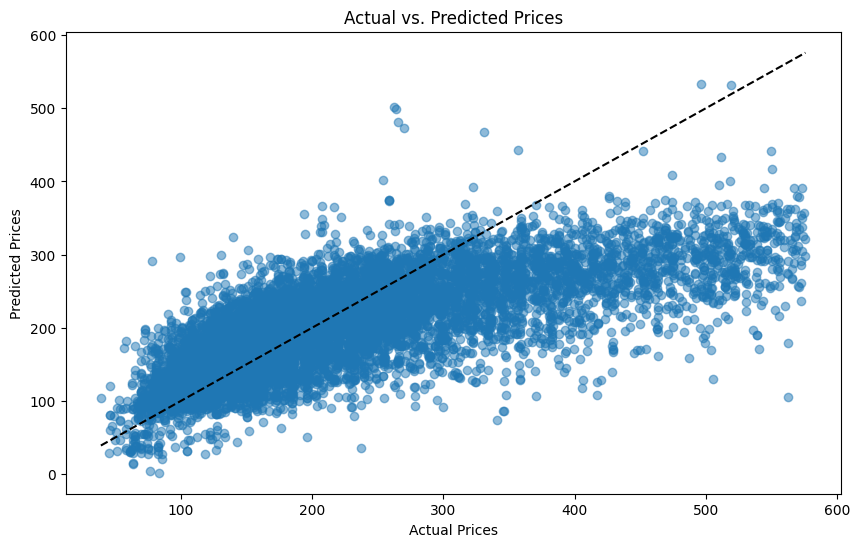

In [44]:
def plot_predictions(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.show()

plot_predictions(best_model, test_loader, device)

# *MLP* Model

## Model Define

In [45]:
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(128, 64)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(64, 32)
#         self.relu3 = nn.ReLU()
#         self.output = nn.Linear(32, 1)

#     def forward(self, x):
#         x = self.relu1(self.fc1(x))
#         x = self.relu2(self.fc2(x))
#         x = self.relu3(self.fc3(x))
#         x = self.output(x)
#         return x

In [46]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 32) 
        self.relu4 = nn.ReLU()
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout(x) 
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.relu4(self.fc4(x))
        x = self.output(x)
        return x

In [47]:
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [48]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.01):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MLP(input_dim=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')
            
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'MLP_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [49]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=1000, batch_size=32, lr=0.0001, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 228.60637364051155
Fold 1, Epoch 2, Validation MAE Loss: 228.47005643092746
Fold 1, Epoch 3, Validation MAE Loss: 228.32458622722706
Fold 1, Epoch 4, Validation MAE Loss: 228.16417773234895
Fold 1, Epoch 5, Validation MAE Loss: 227.9789825692711
Fold 1, Epoch 6, Validation MAE Loss: 227.75313109085272
Fold 1, Epoch 7, Validation MAE Loss: 227.45572766822403
Fold 1, Epoch 8, Validation MAE Loss: 227.01381838470078
Fold 1, Epoch 9, Validation MAE Loss: 226.19939387784459
Fold 1, Epoch 10, Validation MAE Loss: 223.94444768755267
Fold 1, Epoch 11, Validation MAE Loss: 203.79463993563198
Fold 1, Epoch 12, Validation MAE Loss: 69.56522670128534
Fold 1, Epoch 13, Validation MAE Loss: 61.85803406268234
Fold 1, Epoch 14, Validation MAE Loss: 59.475513204994044
Fold 1, Epoch 15, Validation MAE Loss: 57.82667978373801
Fold 1, Epoch 16, Validation MAE Loss: 56.761055609991935
Fold 1, Epoch 17, Validation MAE Loss: 56.075809241330475
Fold 1, Epo

48.90556743194453

In [50]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed_array,
#         y=y,
#         n_splits=5,
#         epochs=100,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

## Test Result

In [51]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_dim=X_train.shape[1]).to(device)
    model.load_state_dict(torch.load('MLP_best_model.pth', map_location=device))
    return model, device

In [52]:
best_model, device = load_best_model(df_transformed.shape[1])

In [53]:
evaluate_model(best_model, test_loader, device)

Test Loss: 47.936803097756496


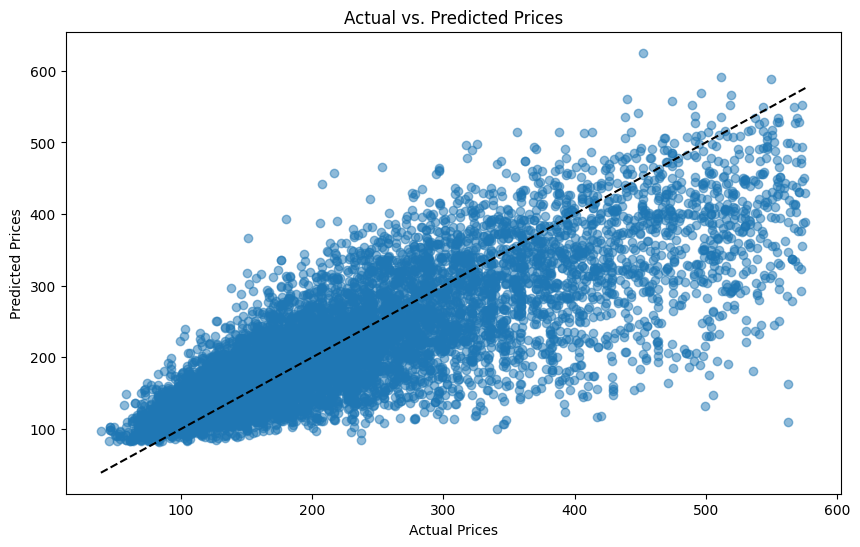

In [54]:
plot_predictions(best_model, test_loader, device)